# Notebook configuration

In [1]:
signal_number   = 4481
bkg_number      = 4447
save_plots      = False
outputfolder    = "plots/{}/".format(signal_number)
corr_filename   = "merged_corrections.h5"
inputfilename_s = "/home/brais/Documents/Next/Cs/data/{0}/dst_{0}.root.h5".format(signal_number)
inputfilename_b = "/home/brais/Documents/Next/Cs/data/{0}/dst_{0}.root.h5".format(bkg_number)

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 3e5
Erange_zcorr  =  5e3, 2e5
Erange_xycorr =  5e3, 2e5
Erange_XR     =  6e3, 12e3
Qrange        =    0, 40e2

S1Erange      =    0, 250
S1Wrange      =    0, 300
S1Hrange      =    0, 400
S2Wrange      =    0, 40
S2Hrange      =    0, 50e3
NSirange      =    0, 30

Zrange_LT     =   50, 350
nX, nY        =   50,  50

# Cs analysis

In [2]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder
from icaro.core.hst_functions import scatter

from copy import copy

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Thu Jul 13 18:20:39 2017


#### General plotting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Useful functions

In [4]:
two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]

def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure()

    #plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))
    plt.savefig("merged_map.pdf")
    """
    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))
    """
    
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

# Read data

In [5]:
signal = dstf.load_dst(inputfilename_s, "DST", "Events")
signal = signal[(signal.R<max(Rrange))] # soft radial cut to reduce badly reconstructed events
print('Signal:')
print(len(signal))


bkg = dstf.load_dst(inputfilename_b, "DST", "Events")
bkg = bkg[(bkg.R<max(Rrange))] # soft radial cut to reduce badly reconstructed events
print('Background:')
print(len(bkg))


Signal:
26052
Background:
86285


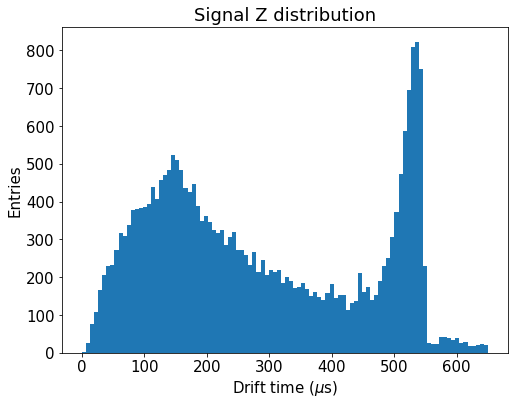

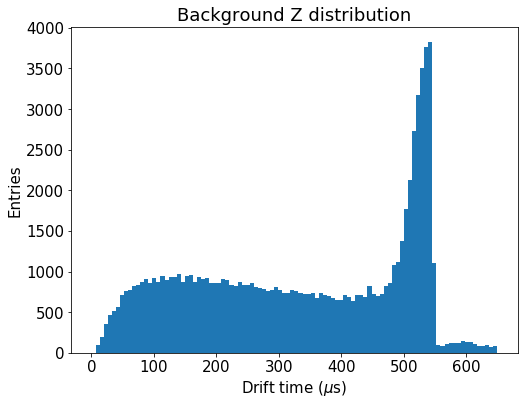

In [6]:
hist(signal.Z, 100, [0,650])
labels("Drift time ($\mu$s)", "Entries", "Signal Z distribution")

hist(bkg.Z   , 100, [0,650])
labels("Drift time ($\mu$s)", "Entries", "Background Z distribution")

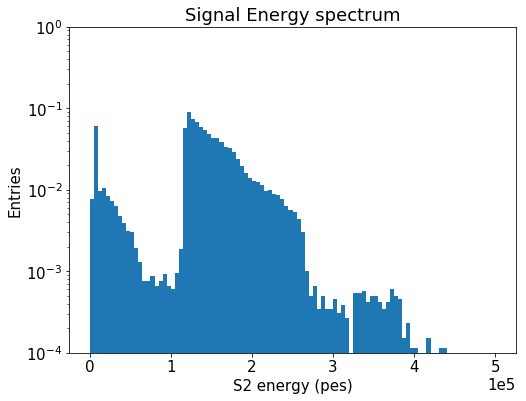

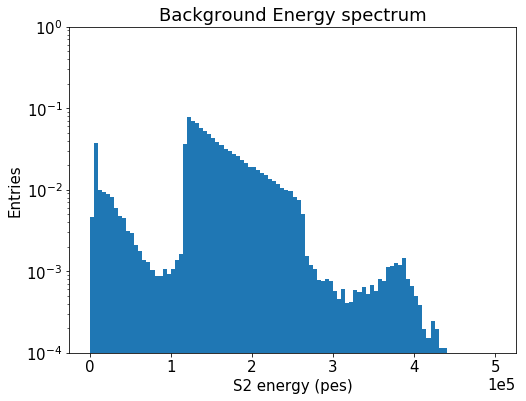

In [7]:
pdf(signal.S2e, 100, (0, 500e3))
labels("S2 energy (pes)", "Entries", "Signal Energy spectrum")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

pdf(bkg.S2e   , 100, (0, 500e3))
labels("S2 energy (pes)", "Entries", "Background Energy spectrum")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


# Lifetime calculation

In [8]:
fid_signal = copy(signal)
fid_signal = fid_signal[(fid_signal.R < 100)] # Fiducialize in order to reduce geometrical effects
print("Signal Ratio:", len(fid_signal)/len(signal))
fid_signal.head()

fid_bkg    = copy(bkg)
fid_bkg    = fid_bkg[(fid_bkg.R < 100)] # Fiducialize in order to reduce geometrical effects
print("Background Ratio:", len(fid_bkg)/len(bkg))
fid_bkg.head()

Signal Ratio: 0.35598034699831105
Background Ratio: 0.32355565857333257


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,173,1.499254e+09,0,1,225.0,38.891422,221.551099,138150.0,42.098750,10471.008789,...,672587.5,36,534.4375,534.4375,91.018479,-20.084223,93.208044,-0.217181,11.993000,12.956591
2,174,1.499254e+09,0,2,175.0,35.007484,180.896436,603475.0,36.387500,17422.484375,...,682412.5,50,78.9375,78.9375,97.298407,-6.068171,97.487449,-0.062286,12.220767,16.477278
4,175,1.499254e+09,0,1,100.0,11.037450,45.281928,605000.0,3.762500,3323.521729,...,671887.5,3,66.8875,66.8875,-6.705740,59.070777,59.450178,1.683833,3.770911,4.925367
21,196,1.499254e+09,0,1,200.0,28.378513,158.390779,370950.0,21.928125,11452.210938,...,657812.5,33,286.8625,286.8625,50.554148,1.478372,50.575760,0.029235,10.658858,14.253619
22,198,1.499254e+09,0,2,175.0,21.006113,113.785879,568550.0,16.625000,17889.601562,...,654687.5,27,86.1375,86.1375,28.673246,-53.565764,60.757272,-1.079316,9.596326,9.682422


# S2 energy fiducialized

### Signal

Energy at z=0 = 9059.0 +- 105.7
Lifetime      = 1011.1 +- 53.3
Chi2          = 6.39          


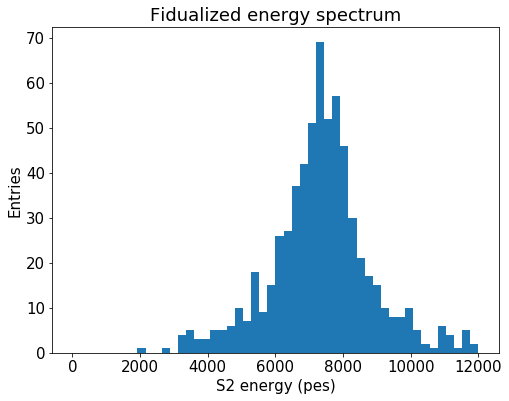

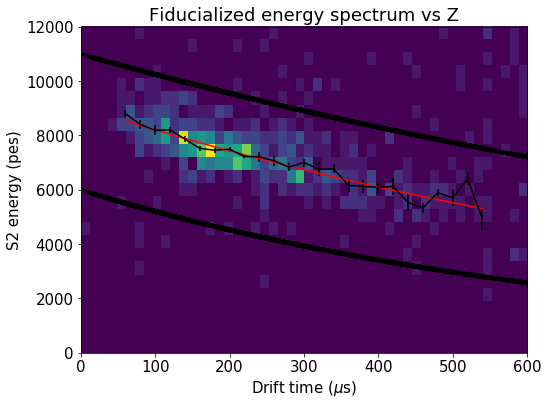

In [9]:
data = fid_signal
hist(data.S2e, 50, range=[0,12e3])
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("S2energy_fiducial")

low_cut   =  6000 * np.exp(-0.0014*data.Z.values)
high_cut  = 11000 * np.exp(-0.0007*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,500), sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr_signal = corrf.LifetimeCorrection(1100, f.errors[1])

### Background

Energy at z=0 = 9137.0 +- 73.5
Lifetime      = 1031.7 +- 34.2
Chi2          = 2.09          


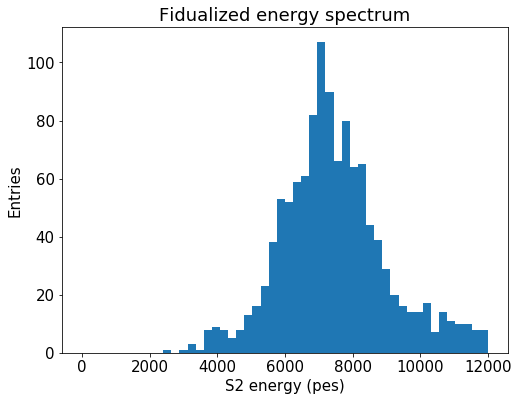

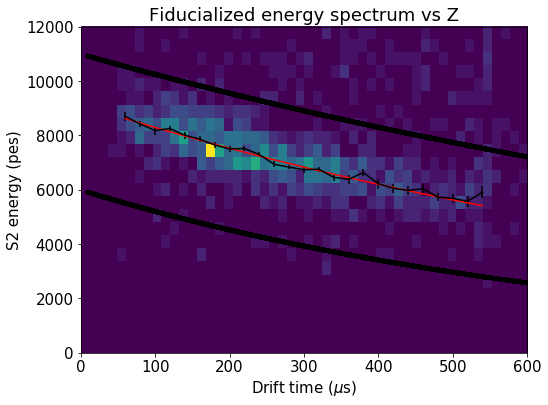

In [10]:
data = fid_bkg
hist(data.S2e, 50, range=[0,12e3])
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("S2energy_fiducial")

low_cut   =  6000 * np.exp(-0.0014*data.Z.values)
high_cut  = 11000 * np.exp(-0.0007*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,500), sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr_bkg = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Event distribution

In [11]:
sel_s    = coref.in_range(signal.S2e, 0e5, 8e5)
sel_s    = np.logical_and(sel_s, coref.in_range(signal.Z, 0     , 400   ))
sel_s    = np.logical_and(sel_s, signal.nS2==1)
#sel_s    = np.logical_and(sel_s, signal.R<50)

signal_s = signal[sel_s]


sel_b    = coref.in_range(bkg.S2e, 0e5, 8e5)
sel_b    = np.logical_and(sel_b, coref.in_range(bkg.Z, 0     , 400   ))
sel_b    = np.logical_and(sel_b, bkg.nS2==1)
#sel_b    = np.logical_and(sel_b, bkg.R<50)

bkg_s    = bkg[sel_b]

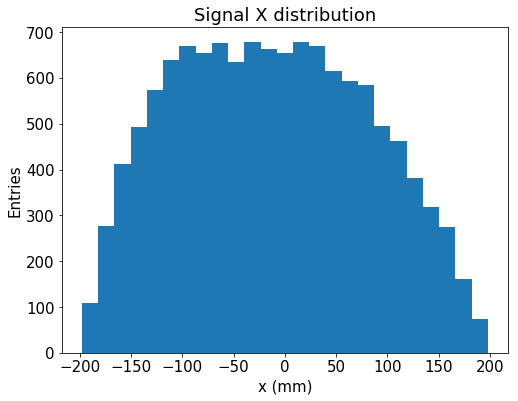

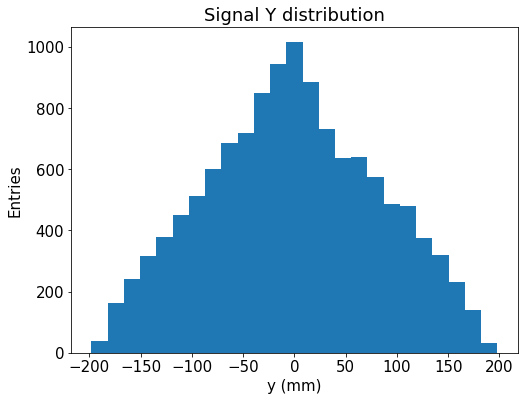

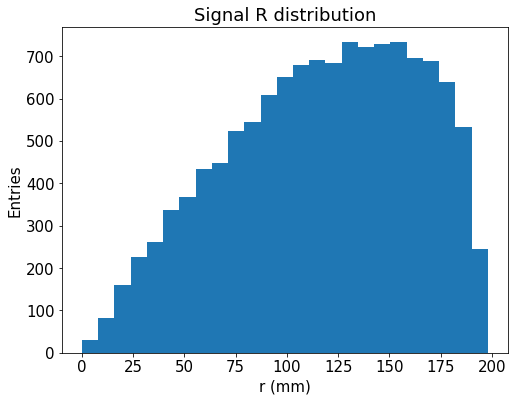

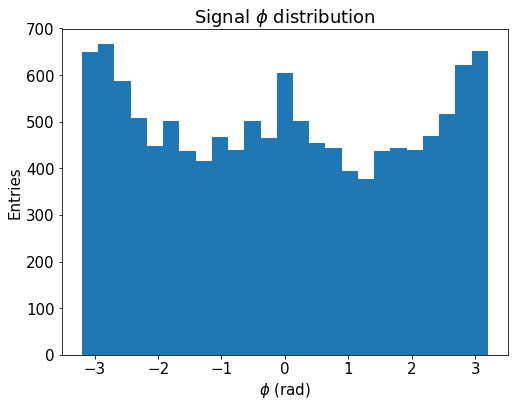

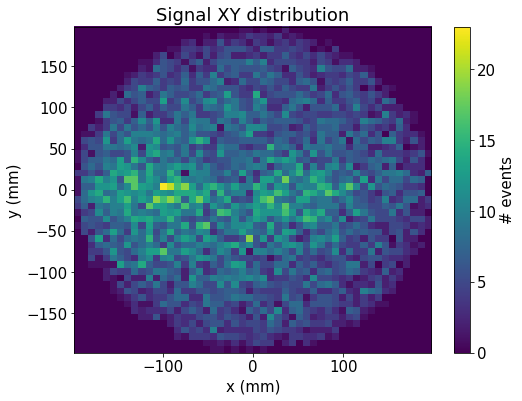

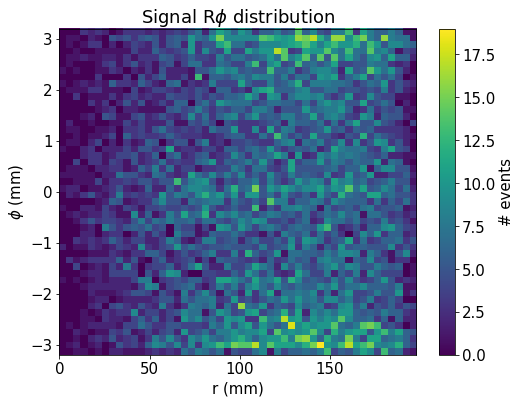

In [12]:
hist(signal_s.X, 25, range=XYrange)
labels("x (mm)", "Entries", "Signal X distribution")
save("Signal X")

hist(signal_s.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Signal Y distribution")
save("Signal Y")

hist(signal_s.R, 25, range=Rrange)
labels("r (mm)", "Entries", "Signal R distribution")
save("Signal R")

hist(signal_s.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "Signal $\phi$ distribution")
save("Signal Phi")

nXY, xs, ys, _ = \
hist2d(signal_s.X, signal_s.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "Signal XY distribution")
save("Signal XY")

hist2d(signal_s.R, signal_s.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "Signal R$\phi$ distribution")
save("Signal RPhi")

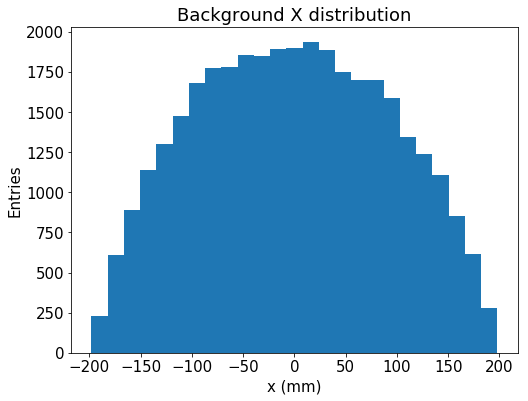

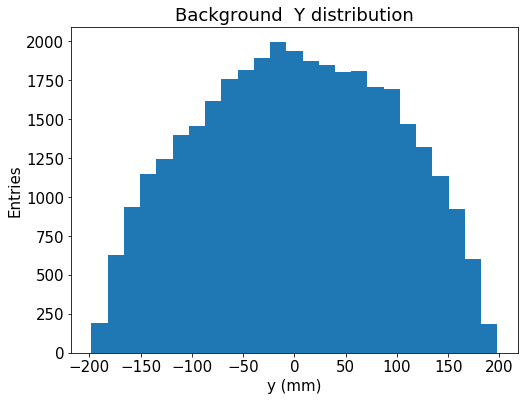

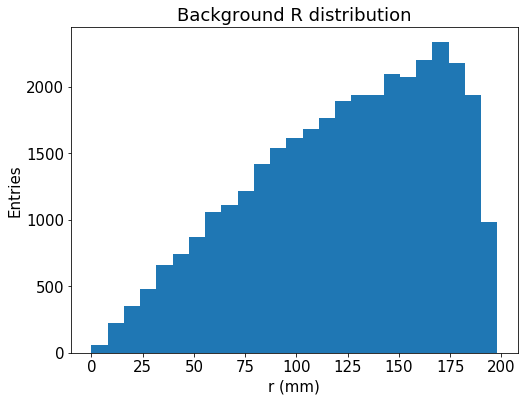

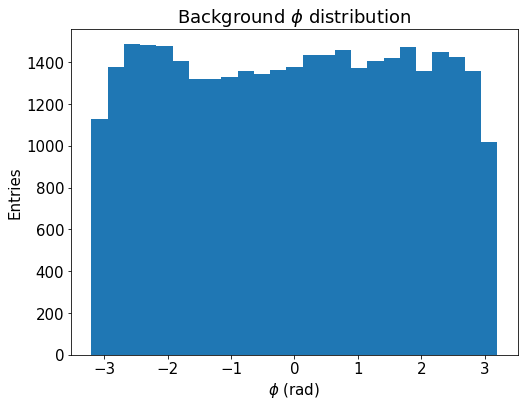

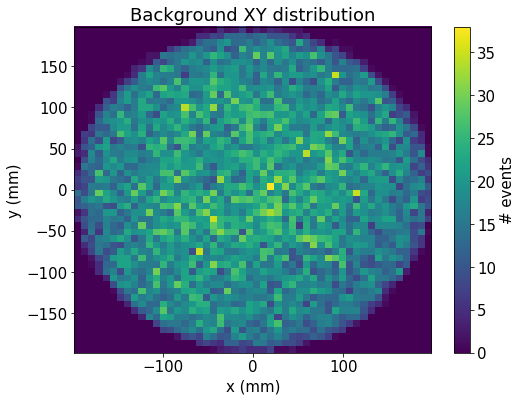

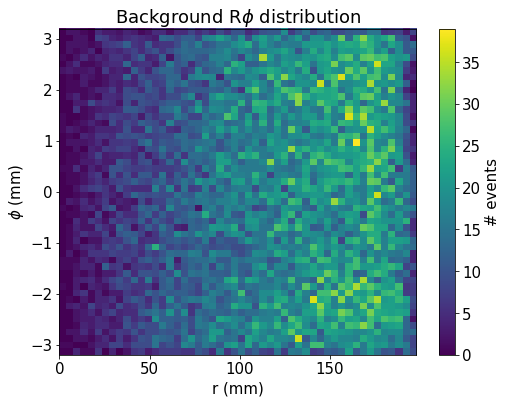

In [13]:
hist(bkg_s.X, 25, range=XYrange)
labels("x (mm)", "Entries", "Background X distribution")
save("Background X")

hist(bkg_s.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Background  Y distribution")
save("Background Y")

hist(bkg_s.R, 25, range=Rrange)
labels("r (mm)", "Entries", "Background R distribution")
save("Background R")

hist(bkg_s.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "Background $\phi$ distribution")
save("Background Phi")

nXY, xs, ys, _ = \
hist2d(bkg_s.X, bkg_s.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "Background XY distribution")
save("Background XY")

hist2d(bkg_s.R, bkg_s.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "Background R$\phi$ distribution")
save("Background RPhi")

# Energy vs position

In [14]:
xy_map = dstf.load_xy_corrections(corr_filename)

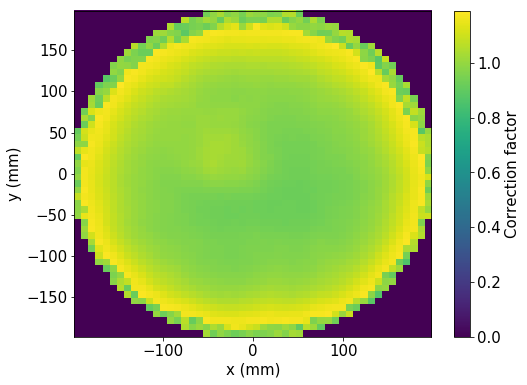

In [15]:
plot_map(xy_map)

In [20]:
Erange_cut = [1.70e5,2.2e5]
nbin       = 100
Zmax       = 400

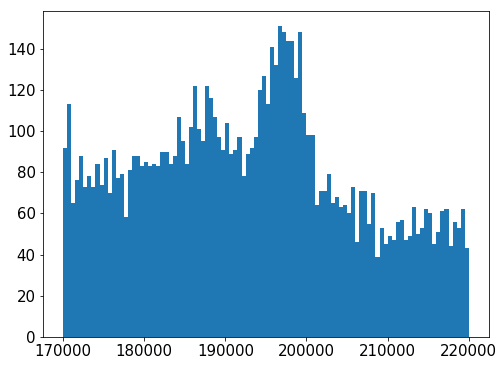

In [21]:
data = signal
data = data
Efid_zcorr = data.S2e.values * Zcorr_signal(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
signal_y, signal_x, a = hist(Efid_zcorr, nbin, range=Erange_cut)
time = data.time.values

signal_y_e  = np.sqrt(signal_y)/(np.max(time)-np.min(time))
signal_y   *= 1./(np.max(time)-np.min(time))


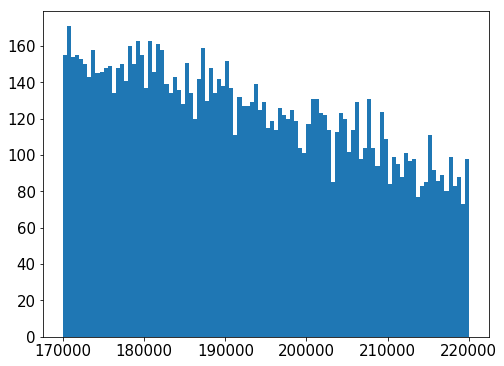

In [22]:
data = bkg
data = data[(data.Z<Zmax)&(data.nS2==1)]
Efid_zcorr = data.S2e.values * Zcorr_bkg(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
bkg_y, bkg_x, a = hist(Efid_zcorr, nbin, range=Erange_cut)
time = data.time.values

bkg_y_e  = np.sqrt(bkg_y)/(np.max(time)-np.min(time))
bkg_y   *= 1./(np.max(time)-np.min(time))


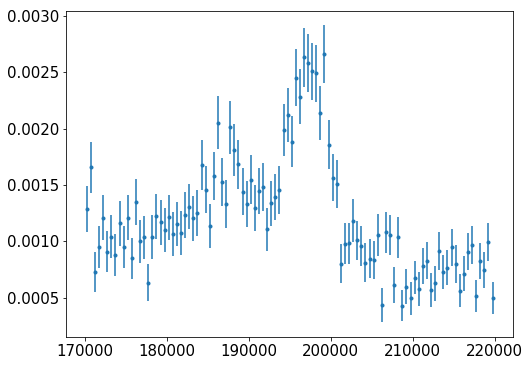

In [23]:
diff = signal_y-bkg_y
err  = np.sqrt(bkg_y_e**2 + signal_y_e**2)
plot = plt.errorbar(bkg_x, diff, yerr= err, fmt='.')

[  1.16070791e+01   1.97241660e+05   2.49353305e+03   7.59316726e-04]
[  8.65805880e-01   1.72986128e+02   2.01679073e+02   3.63953677e-05]


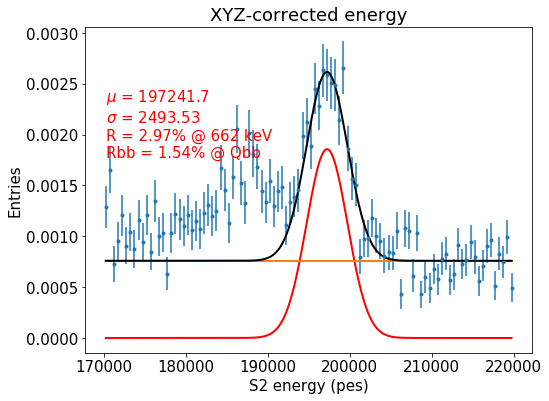

In [28]:
plot = plt.errorbar(bkg_x, diff, yerr= err, fmt='.')

seed =  10,   2.0e5,  1e3, 0.001
low  =  0,     1.95e5, 1e2,  0
upp  =  1000,     2.2e5,  5e4, 10
f    = fitf.fit(one_gauss, bkg_x, diff, seed, fit_range=(1.945e5,2.2e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(bkg_x[0], bkg_x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(bkg_x[0], 1*max(diff)/1.5, gausstext(f.values, 662), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")